# Titanic Survival with DNN

Supervised Learning. Binary classification

Predict survival on the Titanic using an artificial neural network in Keras

This project is based on a dataset containing demographics and passenger information from 891 of the 2224 passengers and crew on board the Titanic. A description of this dataset is on the [Kaggle website](https://www.kaggle.com/c/titanic/data), where the data was obtained.


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import helper

helper.reproducible(seed=9)  # Setup reproducible results from run to run using Keras
sns.set()

Using TensorFlow backend.


## 1. Data processing and Exploratory Data Analysis

In [2]:
original_df = pd.read_csv('data/titanic_data.csv')

target = ['Survived']  # the target will remain the same throughout the notebook

original_features = [f for f in original_df if f not in target] 
original_df = original_df[original_features + target]   # sort columns: target at the end
print("{} rows \n{} columns \n\ntarget: {}".format(*original_df.shape, target))

891 rows 
12 columns 

target: ['Survived']


### Show original data

In [3]:
original_df.head(6)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0
5,6,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,0


#### Numerical Data

In [4]:
original_df.describe(percentiles=[0.5])

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Survived
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,2.308642,29.699118,0.523008,0.381594,32.204208,0.383838
std,257.353842,0.836071,14.526497,1.102743,0.806057,49.693429,0.486592
min,1.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000
50%,446.000000,3.000000,28.000000,0.000000,0.000000,14.454200,0.000000
max,891.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.000000


#### Non-numerical Data

In [5]:
original_df.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Nysten, Miss. Anna Sofia",male,1601,B96 B98,S
freq,1,577,7,4,644


#### Missing values

Missing:
                 Age:    177/891 (19.9%)
               Cabin:    687/891 (77.1%)
            Embarked:      2/891 (0.2%)


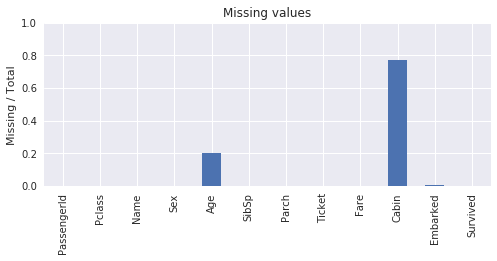

In [6]:
helper.show_missing(original_df, plot=True)

- Binary target "Survived": ~38% ones; F1 score won't be used <br>
- Some values are missing for key values (e.g. Age)
- Some features (e.g. PassengerID, Name, Ticket) seem irelevant to survival probabilities <br> 

### Modify features

#### Enhance and add new features

In [7]:
df = original_df.copy()  # modified dataset

# Cabin: Get first letter
df["Cabin"] = df["Cabin"].str[0]

# get Title from Name
df['Title'] = df["Name"].str.extract('([A-Za-z]+)\.', expand=False)

# remove low frequency values for the new feautres
fields = ['Cabin', 'Title']
df.loc[:, fields] = helper.remove_lowfreq(df.loc[:, fields], show=True)  

# Alone passenger 
df['Alone'] = ((df["SibSp"] + df["Parch"]) == 0)

Cabin {'C': 59, 'B': 47, 'D': 33, 'E': 32, 'A': 15, 'F': 13}
Title {'Mr': 517, 'Miss': 182, 'Mrs': 125, 'Master': 40}


#### Delete irrelevant features


In [8]:
df = df.drop(['PassengerId', 'Name', 'Ticket'], axis='columns')

df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Survived,Title,Alone
0,3,male,22.0,1,0,7.2500,NaN,S,0,Mr,False
1,1,female,38.0,1,0,71.2833,C,C,1,Mrs,False
2,3,female,26.0,0,0,7.9250,NaN,S,1,Miss,True
3,1,female,35.0,1,0,53.1000,C,S,1,Mrs,False
4,3,male,35.0,0,0,8.0500,NaN,S,0,Mr,True


### Sort variables

In [9]:
improved_features = [f for f in df if f not in target]

df = df[improved_features + target]   # sort columns

#numerical = list(df.select_dtypes(include=[np.number]))

numerical = ["Age", "SibSp", "Parch", "Fare"]  # numerical variables (features+target)
categorical = [f for f in df if f not in numerical] # categorical variables (features+target)

print("numerical variables: {}\n".format(numerical))
print("categorical variables: {}\n".format(categorical))
for t in target:
    print("Target {}: {}".format(t, "numerical" if t in numerical else "categorical"))

numerical variables: ['Age', 'SibSp', 'Parch', 'Fare']

categorical variables: ['Pclass', 'Sex', 'Cabin', 'Embarked', 'Title', 'Alone', 'Survived']

Target Survived: categorical


### Visualize the data

#### Optional dataframe without outliers


In [10]:
df_3sigma = df.copy()
num = df[numerical]
df_3sigma[numerical] = num[np.abs(num-num.mean())<=(3*num.std())]

#### Categorical features

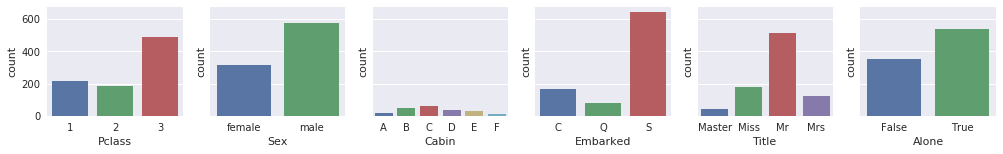

In [11]:
helper.show_categorical(df, categorical, target=target, sharey=True)

#### Target vs Categorical features

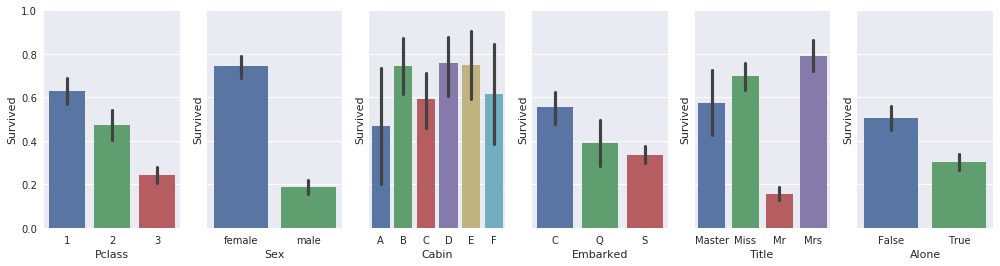

In [12]:
# Target vs Categorical features
helper.show_target_vs_categorical(df, target, categorical)
plt.ylim([0, 1]);

#### Numerical features

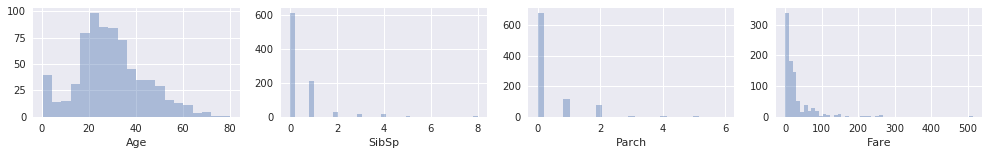

In [13]:
helper.show_numerical(df, numerical, kde=False)
#helper.show_numerical(df_3sigma, numerical, kde=False)

#### Target vs numerical features

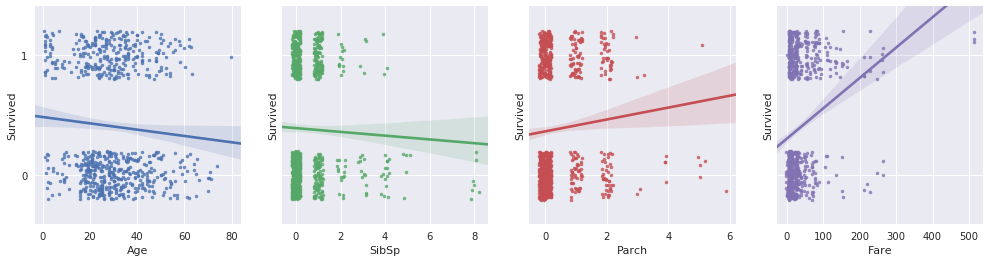

In [14]:
helper.show_target_vs_numerical(df, target, numerical, jitter=0.2)
plt.ylim([-0.4, 1.4])
plt.yticks([0,1]);
# helper.show_target_vs_numerical(df_3sigma, target, numerical, jitter=0.2)

#### Correlation between numerical features and target

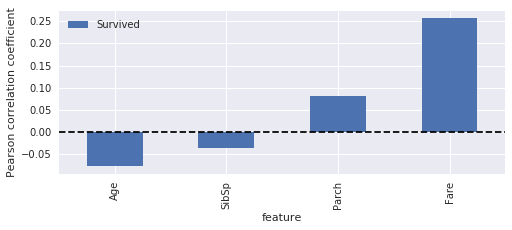

In [15]:
corr = df.corr().loc[numerical, target]

corr.plot.bar(figsize=(8, 3))
plt.axhline(y=0, color='k', linestyle='--',)
plt.xlabel('feature')
plt.ylabel('Pearson correlation coefficient');
#sns.heatmap(corr, cmap="bwr")

#### Most relevant features

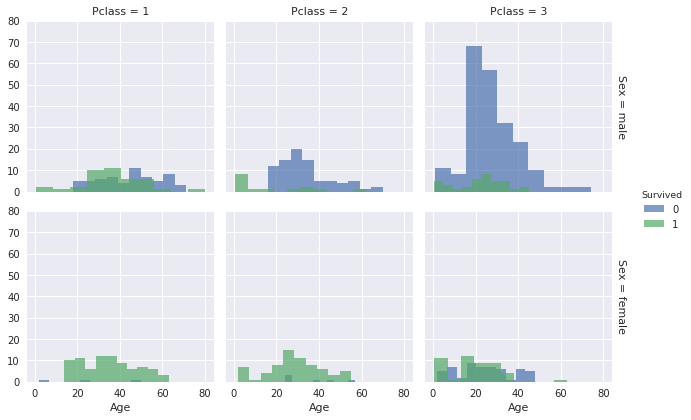

In [16]:
sns.FacetGrid(df, row = "Sex", col="Pclass",hue="Survived", size=3,
              margin_titles=True).map(plt.hist, "Age", alpha=.7).add_legend();
plt.ylim([0, 80]);
# df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean().sort_values(by='Survived', ascending=False)
#male_df = df[df['Sex']=='male']
# helper.show_target_vs_categorical(df.loc[(df['Age']<12) | (df['Sex']=='female')], target, categorical)

-  Unlike in third class, most children and women in first and second classes survived.

### Fill missing values

In [17]:
helper.show_missing(original_df)

Missing:
                 Age:    177/891 (19.9%)
               Cabin:    687/891 (77.1%)
            Embarked:      2/891 (0.2%)


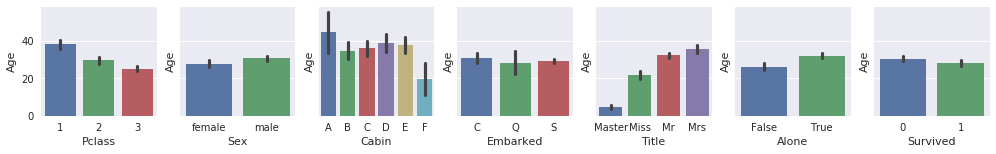

In [18]:
# Fill Age
helper.show_target_vs_categorical(df, ["Age"], categorical, figsize=(17,2))

In [19]:
# the median of Age for different Pclass and Tittle will be used
ref = df[['Pclass', 'Title', 'Age']].groupby(['Pclass', 'Title'], as_index=False).median()
ref.rename(columns={'Age': 'Age_median'}, inplace=True)
ref

,Pclass,Title,Age_median
0,1,Master,4.0
1,1,Miss,30.0
2,1,Mr,40.0
3,1,Mrs,41.5
4,2,Master,1.0
5,2,Miss,24.0
6,2,Mr,31.0
7,2,Mrs,32.0
8,3,Master,4.0
9,3,Miss,18.0


In [20]:
# add Age_median temporary to the data to fill NaNs
df = df.merge(ref[['Pclass', 'Title', 'Age_median']], on=['Pclass', 'Title'], how='left')
df['Age'].fillna(df['Age_median'], inplace=True)
df.drop('Age_median', axis='columns', inplace=True)

In [21]:
# fill missing categorical values with the mode (if any)
modes = df[categorical].mode()   # this solves fillna issue with mode()   
for idx, f in enumerate(df[categorical]):
    df[f] = df[f].fillna(modes.iloc[0,idx])

In [22]:
# fill missing numeric NaN values with the median (if any)
df = df.fillna(df.median())  

## 2. Neural Network model

### Select the features for the model

In [23]:
drop = ['Fares']  # features to drop
features = [f for f in improved_features if f not in drop]

# From now use data instead of df
data = df[features + target]
data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title,Alone,Survived
0,3,male,22.0,1,0,7.2500,C,S,Mr,False,0
1,1,female,38.0,1,0,71.2833,C,C,Mrs,False,1
2,3,female,26.0,0,0,7.9250,C,S,Miss,True,1
3,1,female,35.0,1,0,53.1000,C,S,Mrs,False,1
4,3,male,35.0,0,0,8.0500,C,S,Mr,True,0


### Normalize numerical variables

Shift and scale the variables such that they have zero mean and a standard deviation of 1. The scaling factors are saved so we can go backwards when we use the network for predictions.

In [24]:
scaled_features = {}
for f in numerical:
    if f in (features + target):
        mean, std = data[f].mean(), data[f].std()
        scaled_features[f] = [mean, std]
        data[f] = (data[f] - mean)/std

data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title,Alone,Survived
0,3,male,-0.528175,0.432550,-0.473408,-0.502163,C,S,Mr,False,0
1,1,female,0.658128,0.432550,-0.473408,0.786404,C,C,Mrs,False,1
2,3,female,-0.231600,-0.474279,-0.473408,-0.488580,C,S,Miss,True,1
3,1,female,0.435696,0.432550,-0.473408,0.420494,C,S,Mrs,False,1
4,3,male,0.435696,-0.474279,-0.473408,-0.486064,C,S,Mr,True,0


### Create dummy features

In [25]:
# Only features,target one-hot encode is performed later
for f in categorical:
    if f in features:  
        dummies = pd.get_dummies(data[f], prefix=f, drop_first=False)
        data = pd.concat([data, dummies], axis=1)
        data.drop(f, axis=1, inplace=True)            

nn_features = [f for f in list(data) if f not in target]  # neural networks features

data = data[nn_features + target]  # reorder columns (target last)

### Split the data into training, and test sets

In [26]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data,  test_size=0.25, random_state=9)

# Separate the data into features and target (x=features, y=target)
x_train, y_train_nc = train.drop(target, axis=1).values, train[target].values
x_test, y_test_nc = test.drop(target, axis=1).values, test[target].values
# _nc: non-categorical yet (needs one-hot encoding)

### One-hot encode the output

In [27]:
num_classes = 2
y_train = keras.utils.to_categorical(y_train_nc, num_classes)
y_test = keras.utils.to_categorical(y_test_nc, num_classes)
print(x_train.shape ,y_train.shape)
print(x_test.shape,y_test.shape)

(668, 24) (668, 2)
(223, 24) (223, 2)


### Build the Neural Network

In [28]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout

def build_nn(summary=False):
    input_nodes = x_train.shape[1]
    weights = keras.initializers.RandomNormal(stddev=0.001)

    model = Sequential()
    model.add(Dense(input_nodes, input_dim=x_train.shape[1], activation='relu',
                   kernel_initializer=weights,
                   bias_initializer = 'zero'))
    model.add(Dropout(.2))
    model.add(Dense(2,activation='softmax',
                   kernel_initializer = weights,
                   bias_initializer = 'zero'))
    if summary:
        model.summary()

    model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

model = build_nn(summary=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 24)                600       
_________________________________________________________________
dropout_1 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 50        
Total params: 650
Trainable params: 650
Non-trainable params: 0
_________________________________________________________________


### Train the Neural Network


Training ....
time: 	 1.1 s


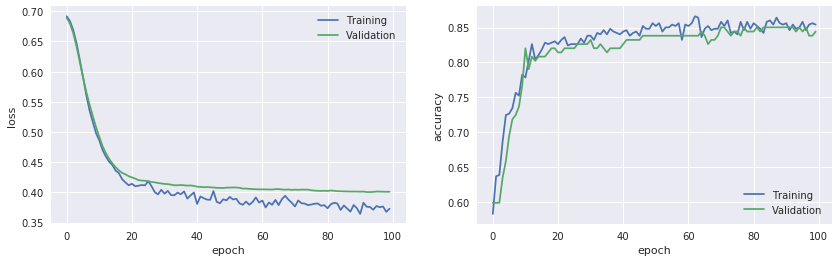


Training loss:  	0.3731
Validation loss: 	0.4011

Training accuracy: 	0.85
Validation accuracy:	0.84


In [29]:
from time import time

model_path = os.path.join("models", "titanic.h5")

def train_nn(model, path=False):
    print('\nTraining ....')
    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0)]
    t0 = time()
    history = model.fit(x_train, y_train, epochs=1000, batch_size=64, verbose=0, validation_split=0.25, callbacks=callbacks)
    print("time: \t {:.1f} s".format(time() -t0))
    helper.show_training(history)
    if path:
        model.save(path)
        print("\nModel saved at",path)

model = build_nn(summary=False)
train_nn(model, path=False)

### Evaluate the model

In [30]:
def evaluate_nn(model, path=model_path):
    print("Model loaded:", model_path)

    score = model.evaluate(x_test, y_test, verbose=0)
    print("\nTest Accuracy: {:.2f}".format(score[1]))

#model = keras.models.load_model(model_path)
evaluate_nn(model)

Model loaded: models/titanic.h5

Test Accuracy: 0.82


### Make predictions

In [31]:
def manual_predict(new_entries):
    """
    input: dictionary of new entries index: features values
    """
    
    # create a dataframe for the new entries only
    new_df = pd.DataFrame(columns=list(df[features]))
    for key, value in new_entries.items():
        new_df.loc[key] = value    
    
    new_data = new_df
    # create dummy features    
    for f in categorical:
        if f in features:  
            dummies = pd.get_dummies(new_data[f], prefix=f, drop_first=False)
            new_data = pd.concat([new_data, dummies], axis=1)
            new_data.drop(f, axis=1, inplace=True)   
       
    # add missing dummies
    missing = set(nn_features) - set(new_data)  # nn_features: ordered neural network features (with dummies)
    for m in missing:
        new_data[m] = 0
        
    # order columns
    new_data = new_data[nn_features]
    
    for f in numerical:
        if f in features:
            new_data.loc[:, f] = (new_data[f] - scaled_features[f][0]) / scaled_features[f][1]    
      
    # make prediction
    for index, row in new_data.iterrows():    
        single_pred = model.predict(np.array([row]))    
        print('{}:\t {:.0f}%'.format(index,single_pred[0,1] * 100))

In [32]:
# input data format
df[features].describe()

,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000
mean,2.308642,29.123648,0.523008,0.381594,32.204208
std,0.836071,13.487280,1.102743,0.806057,49.693429
min,1.000000,0.420000,0.000000,0.000000,0.000000
25%,2.000000,21.000000,0.000000,0.000000,7.910400
50%,3.000000,26.000000,0.000000,0.000000,14.454200
75%,3.000000,36.250000,1.000000,0.000000,31.000000
max,3.000000,80.000000,8.000000,6.000000,512.329200


In [33]:
df[features].describe(include=['O'])

,Sex,Cabin,Embarked,Title
count,891,891,891,891
unique,2,6,3,4
top,male,C,S,Mr
freq,577,751,646,544


In [34]:
new_passengers = {'Average man':    [2, 'male',   26, 1, 0, 14, 'C', 'S', 'Mr', 0],
                  'Average woman':  [2, 'female', 26, 1, 0, 14, 'C', 'S', 'Mrs', 0],
                  'Alone woman 3c': [3, 'female', 26, 0, 0, 8,  'C', 'S', 'Miss', 1],
                  'Boy 1c ':        [1, 'male',   7, 0, 2, 31, 'C', 'S', 'Master', 0],
                  'Boy 2c ':        [1, 'male',   7, 0, 2, 14, 'C', 'S', 'Master', 0],
                  'Boy 3c ':        [3, 'male',   7, 0, 2, 8,  'C', 'S', 'Master', 0],
                  'Girl 3c':        [1, 'female', 7, 0, 2, 8, 'C', 'S', 'Miss', 0],
                 }

print('Survival Probabilities: \n')
manual_predict(new_passengers)

Survival Probabilities: 

Average man:	 10%
Average woman:	 90%
Alone woman 3c:	 55%
Boy 1c :	 91%
Boy 2c :	 91%
Boy 3c :	 55%
Girl 3c:	 91%


The results predicted from the model confirm the impact of the sex for the survival probabilities, as well as the class for the survival of women and children.

### Compare with non-neural network models

#### Classical Machine Learning

In [35]:
helper.ml_models(x_train, y_train, x_test, y_test)


 Naive Bayes 
 --------------------
Test Accuracy:  	 0.79
Training Time:  	 0.9 ms

 SVM 
 --------------------
Test Accuracy:  	 0.80
Training Time:  	 16.7 ms

 Decision Trees 
 --------------------
Test Accuracy:  	 0.75
Training Time:  	 1.9 ms

 KNeighbors 
 --------------------
Test Accuracy:  	 0.80
Training Time:  	 0.7 ms

 AdaBoost 
 --------------------
Test Accuracy:  	 0.79
Training Time:  	 66.6 ms

 Random Forest 
 --------------------
Test Accuracy:  	 0.80
Training Time:  	 132.3 ms
